In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
if not os.path.exists("OSAT") and os.path.exists(
    "../OSAT"
):  # hack to allow scripts to be placed in subdirectories next to AlOlivThermo:
    sys.path.insert(1, os.path.abspath(".."))

from OSAT import thermometers

In [2]:
def sp_model(crno, mg):  # calculate spinel composition from stoichiometry
    crno = crno
    mg = mg
    fe2 = 1 - mg
    fe3fe2 = 0.5
    fe3 = fe2 * fe3fe2
    cr = (2 - fe3 )* crno
    al = cr * (1/crno - 1)
    octa = cr + al + fe3
    tet = octa / 2
    feo = (fe2 + fe3) * 71.844
    mgo = mg * 40.3044
    al2o3 = al / 2 * 101.96
    cr2o3 = cr / 2 * 151.99
    sum_oxide = feo + mgo + al2o3 + cr2o3
    # normaliza composition to 100
    norm_feo = feo / sum_oxide * 100
    norm_mgo = mgo / sum_oxide * 100
    norm_al2o3 = al2o3 / sum_oxide * 100
    norm_cr2o3 = cr2o3 / sum_oxide * 100
    return norm_feo, norm_mgo, norm_al2o3, norm_cr2o3

In [3]:
# Eq. 5 
def thermo_pred_al(df):
    def poly_thermo(data_train, a, b, c, d, e, f, g, h, i, j, k, l, m, n,  p, r):
        return (
        a
        * (df["lnkd"] + r)
        / (
            +b * df["reg_X2(1+X4-X2)"]
            + c * df["reg_(1-X2)X3"]
            + d * df["reg_(1-X2)X4"]
            + e * df["reg_(1-X2)X5"]
            + f * df["reg_X3(X3+X4+X5)"]
            + g * df["reg_X4(X3+X4+X5)"]
            + h * df["reg_X5(X3+X4+X5)"]
            + i * df["reg_X3X4"]
            + j * df["reg_X3X5"]
            + k * df["reg_X4X5"]
            + l * df["reg_X2pow0.5"]
            + m * df["reg_X2pow2"]
            + n * df["reg_X2"]
        )
        + p
    )
    df = df.copy()
    popt = np.array([-1.68118521e-01,  3.90197643e-01,  9.19774257e-03, -2.49266643e+00,
        6.46891489e-02, -3.07131662e-02, -4.14143648e+00, -4.27844629e-01,
        4.63710203e+00,  5.45307660e-02,  1.08027441e+01, -6.30188015e-01,
       -5.93120349e-01,  1.48669890e+00,  2.71379230e+00,  6.54194424e-01])
    df["t_thermo_al"] = 10000/poly_thermo(df, *popt)-273.15
    return df

# model case 1): Fe-Mg reequilibration in spinel

In [4]:
sp_df = pd.DataFrame(columns=['SiO2', 'TiO2', 'MnO', 'FeO', 'MgO', 'Al2O3', 'Cr2O3'])  # create dataframe collecting spinel data. this is needed because eq.5 is in a dataframe structure

In [5]:
# this block is extremely slow in dataframe
crno_array = np.arange(0.4, 0.9, 0.01)  # spinel cr# from 0.4 to 0.9
mg_array = np.arange(0.3, 1, 0.01)  # spinel mg# from 0.3 to 1

sp_res_array = np.zeros((len(crno_array), len(mg_array), 4))  # create spinel matrix to collect spinel composition
sp_t = np.zeros((len(crno_array), len(mg_array), 1))  # create sp_t matrix to collect temperature estimation results

ol_al = 0.05  # fix olivine al2o3 at 0.05 wt.%

for idx, cr_val in enumerate(crno_array):
    for idx2, mg_val in enumerate(mg_array):
        sp_res_array[idx][idx2] = sp_model(cr_val, mg_val)
        feo, mgo, al2o3, cr2o3 = sp_model(cr_val, mg_val)
        sp_df.loc[0, :] = [0, 0, 0, *sp_model(cr_val, mg_val)]
        sp_df_merge = sp_df.join(thermometers._conSpn(sp_df))
        sp_cr2o3 = sp_df_merge['Cr2O3'].values[0]
        sp_al2o3 = sp_df_merge['Al2O3'].values[0]
        sp_df_merge['lnkd'] = np.log(ol_al / sp_al2o3)
        temp = thermo_pred_al(sp_df_merge)['t_thermo_al'].values[0]
        sp_t[idx][idx2] = temp


Text(0, 0.5, 'Spinel Cr#')

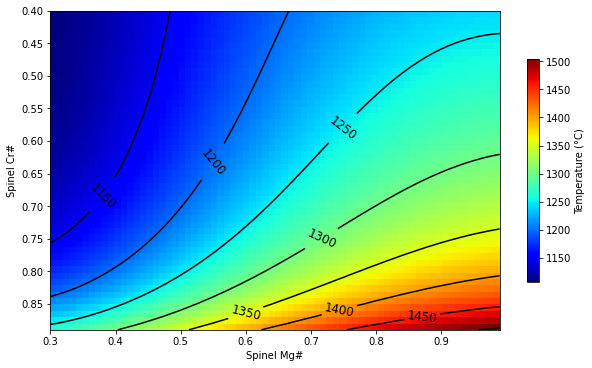

In [6]:
fig, axes = plt.subplots(figsize=(9,5), constrained_layout=True)
contours = axes.contour(mg_array, crno_array, sp_t.reshape(len(crno_array),len(mg_array)),  colors='k', zorder=100)
axes.clabel(contours, inline=1, fontsize=12)
a1 = axes.imshow(sp_t, cmap="jet", extent = [mg_array[0] , mg_array[-1], crno_array[-1] , crno_array[0]])
cbar = plt.colorbar(a1, shrink=.7,)
cbar.set_label('Temperature (°C)')
axes.set_yticks(np.arange( crno_array[0], crno_array[-1] ,0.05))
axes.set_xlabel('Spinel Mg#')
axes.set_ylabel('Spinel Cr#')

# model case 2): Decoupled substitution

In [7]:
ol_cr = np.arange(0.02, 0.15, 0.001)  # create cr variation in olivine
sp_t_cr_array = np.zeros((len(crno_array), len(ol_cr), 1))  # create spinel matrix to collect results

ol_al = 0.05
for idx, cr_val in enumerate(crno_array):
    for idx2, mg_val in enumerate(mg_array):
        feo, mgo, al2o3, cr2o3 = sp_model(cr_val, mg_val)
        for idx3, olcr_val in enumerate(ol_cr):
            kdcr = np.log(olcr_val/cr2o3)
            kdal = np.log(ol_al/al2o3)
            crno = cr_val
            sp_t_cr_array[idx][idx3] = 10000 / (0.0488 -0.6572 * kdal -0.3886	* kdcr + 0.5427 * crno) - 273.15

Text(0, 0.5, 'Spinel Cr#')

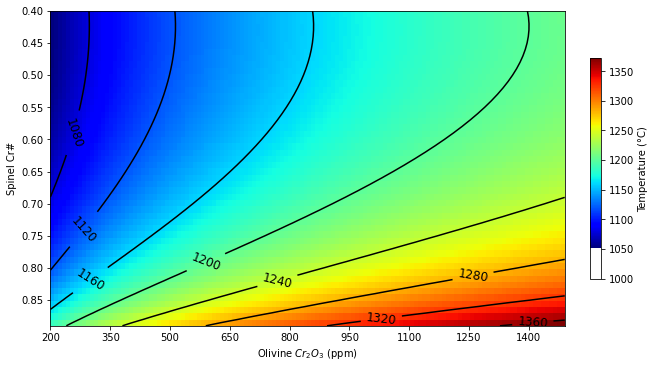

In [8]:
fig, axes = plt.subplots(figsize=(9,5), constrained_layout=True)

contours = axes.contour(ol_cr*10000, crno_array, sp_t_cr_array.reshape(len(crno_array),len(ol_cr)), colors='k')

axes.clabel(contours, inline=1, fontsize=12)

a1 = axes.imshow(sp_t_cr_array, cmap="jet", extent = [ol_cr[0] * 10000, ol_cr[-1] * 10000 , crno_array[-1] , crno_array[0]], aspect='auto')

cbar = plt.colorbar(a1, shrink=.7,)
cbar.set_ticks(np.arange(1000, 1400, 50))
cbar.set_label('Temperature (°C)')

axes.set_xticks(np.arange(ol_cr[0] * 10000, ol_cr[-1] * 10000 ,150))
axes.set_yticks(np.arange( crno_array[0], crno_array[-1] ,0.05))
axes.set_xlabel('Olivine $Cr_2O_3$ (ppm)')
axes.set_ylabel('Spinel Cr#')

# model case 3): coupled substitution (Al:Cr = 1:1)

In [9]:
ol_cr = np.arange(0.02, 0.15, 0.001)  # create cr variation in olivine
sp_t_cr_couple_array = np.zeros((len(crno_array), len(ol_cr), 1))  # create spinel matrix to collect results

ol_al = ol_cr / 151.99 * 101.96 # keep Cr/Al = 1 in olivine

for idx, cr_val in enumerate(crno_array):
    for idx2, mg_val in enumerate(mg_array):
        feo, mgo, al2o3, cr2o3 = sp_model(cr_val, mg_val)
        for idx3, olcr_val in enumerate(ol_cr):
            kdcr = np.log(olcr_val/cr2o3)
            kdal = np.log(ol_al[idx3]/al2o3)
            crno = cr_val
            sp_t_cr_couple_array[idx][idx3] = 10000 / (0.0488 -0.6572 * kdal -0.3886	* kdcr + 0.5427 * crno) - 273.15


Text(0, 0.5, 'Spinel Cr#')

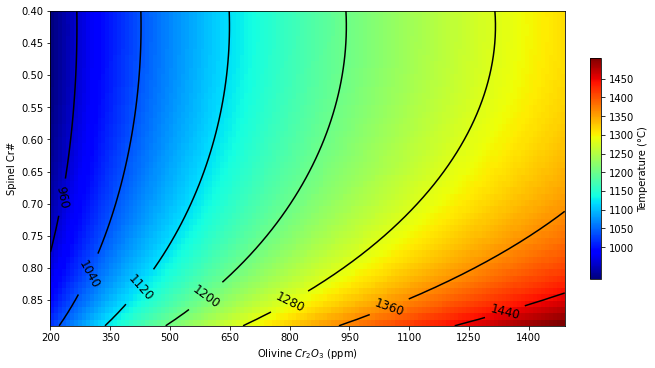

In [11]:
fig, axes = plt.subplots(figsize=(9,5), constrained_layout=True)

contours = axes.contour(ol_cr*10000, crno_array, sp_t_cr_couple_array.reshape(len(crno_array),len(ol_cr)), colors='k')

axes.clabel(contours, inline=1, fontsize=12)

a1 = axes.imshow(sp_t_cr_couple_array, cmap="jet", extent = [ol_cr[0] * 10000, ol_cr[-1] * 10000 , crno_array[-1] , crno_array[0]], aspect='auto')

cbar = plt.colorbar(a1, shrink=.7,)
cbar.set_ticks(np.arange(1000, 1500, 50))
cbar.set_label('Temperature (°C)')

axes.set_xticks(np.arange(ol_cr[0] * 10000, ol_cr[-1] * 10000 ,150))
axes.set_yticks(np.arange( crno_array[0], crno_array[-1] ,0.05))
axes.set_xlabel('Olivine $Cr_2O_3$ (ppm)')
axes.set_ylabel('Spinel Cr#')